In [2]:
from sklearn.datasets import fetch_openml 

## Load mnist data and let observe it for a bit

In [4]:
mnist = fetch_openml('mnist_784', version=1)

In [6]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [39]:
print(f'input shape {mnist["data"].shape}')
print(f'label shape {mnist["target"].shape}')

print(f'type input : {type(mnist["data"][0])}')
print(f'type input : {type(mnist["target"][0])}')

# convert mnist target to int
mnist_label = mnist['target'].astype('int')

input shape (70000, 784)
label shape (70000,)
type input : <class 'numpy.ndarray'>
type input : <class 'str'>


In [41]:
X_train, X_test = mnist['data'][:60000], mnist['data'][60000:]
y_train, y_test = mnist_label[:60000], mnist_label[60000:]

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import random

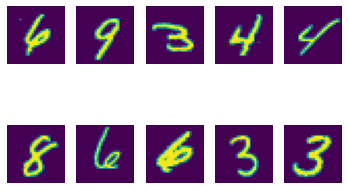

In [34]:
# explore some input

num_show = 10

for i in range(10):
    idx = random.randint(0, mnist['data'].shape[1]-1)
    plt.subplot(2, 5, i+1)
    img = mnist['data'][idx].reshape(28, 28)
    plt.imshow(img)
    plt.axis('Off')

## Begin using ml to predict the mnist dataset
* Note that at the first step we just at least need to classify only 2 class, 9 or not 9  
* Then, comparing the performance index using accuracy, precision, recall, and f1 score  
* Try plotting recall/precision versus threshold curve to obeserve the impact of choosing threshold value  
* Finally, choosing the appropriate threshold such that the model have precision at least 90% at the best possible recall


In [42]:
from sklearn.linear_model import SGDClassifier

In [43]:
# we will use sgdclassifier which is SVM by default
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [64]:
import joblib
import pickle
import time
import os

os.makedirs('saved_model/mnist-classification', exist_ok=True)

# test dump time
# st = time.time()
# joblib.dump(sgd_clf, 'saved_model/multiclasssvm-model-joblib')
# print(f'elapsed time {time.time() - st }')


st = time.time()
with open('saved_model/multiclass-svm-model', 'wb') as f:

    pickle.dump(sgd_clf, f)

print(f'elapsed time {time.time() - st }')

elapsed time 0.0034456253051757812


In [57]:
# test load time
# st = time.time()
# load_moedl = joblib.load('saved_model/svm-model-joblib')
# print(f'elapsed time {time.time() - st }')


st = time.time()
with open('saved_model/svm-model-pickle', 'rb') as f:
    load2_model = pickle.load(f)

print(f'elapsed time {time.time() - st }')

elapsed time 0.0028600692749023438
elapsed time 0.0021750926971435547


In [63]:
print(sgd_clf.score(X_train, y_train))
print(sgd_clf.score(X_test, y_test))

0.8608166666666667
0.846
